In [ ]:
%%capture
!pip install mujoco==2.3.3

In [ ]:
%env MUJOCO_GL=egl

env: MUJOCO_GL=egl


## **Importing Required Libraries**

This cell imports essential libraries for implementing and visualizing Deep Deterministic Policy Gradient (DDPG) and Soft Actor-Critic (SAC). The key components include:


In [ ]:
from   torch.optim import Adam
import torch
import torch.nn as nn
import torch.nn.functional as F
from   torch.distributions import Normal
import random
import numpy as np
import logging
import matplotlib
import matplotlib.pyplot as plt
import imageio
from IPython.display import HTML
from base64 import b64encode
import gymnasium as gym



is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display



logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)

## **Logging, Visualization, and Video Playback Functions**


In [ ]:
def plot_rewards(sum_of_rewards, show_result=None , bove = None,dn = None):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result is not None:
        plt.title(f'{show_result}')
    else:
        plt.clf()
        plt.title('Training...')
    if bove is not None:
        plt.xlabel(f'{bove}')
    else:
        plt.xlabel('Episode')
    if dn is not None:
        plt.xlabel(f'{dn}')
    else:
        plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())
def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url)

## **Replay Memory for Experience Replay**

This class implements a **Replay Buffer**, a crucial component in off-policy reinforcement learning algorithms like DDPG and SAC. The buffer stores past experiences and allows the agent to sample them randomly, breaking correlation between consecutive samples and improving learning stability.

In [ ]:
class ReplayMemory:
    def __init__(self, capacity, seed):
        random.seed(seed)
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        # print(self.position)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = int((self.position + 1) % self.capacity)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

## **Neural Networks for DDPG and SAC**

This cell defines key neural networks used in **Deep Deterministic Policy Gradient (DDPG)** and **Soft Actor-Critic (SAC)** algorithms.


- **`GaussianPolicy`**: A stochastic policy for SAC, using Gaussian action sampling.
- **`DeterministicPolicy`**: A deterministic actor for DDPG, applying action bounds.

In [ ]:
# Initialize Policy weights
def weights_init_(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=1)
        torch.nn.init.constant_(m.bias, 0)


class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, hidden_dim):
        super(ValueNetwork, self).__init__()

        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)

        self.apply(weights_init_)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x


class QNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim):
        super(QNetwork, self).__init__()

        # Define two separate Q-networks (Q1 and Q2) for twin Q-learning.
        self.linear1_q1 = nn.Linear(num_inputs + num_actions, hidden_dim)
        self.linear2_q1 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3_q1 = nn.Linear(hidden_dim, 1)

        self.linear1_q2 = nn.Linear(num_inputs + num_actions, hidden_dim)
        self.linear2_q2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3_q2 = nn.Linear(hidden_dim, 1)

        self.apply(weights_init_)

    def forward(self, state, action):
        # Concatenate state and action as input
        xu = torch.cat([state, action], dim=-1)

        # Compute Q-values for Q1 network
        x1 = F.relu(self.linear1_q1(xu))
        x1 = F.relu(self.linear2_q1(x1))
        Q1 = self.linear3_q1(x1)

        # Compute Q-values for Q2 network
        x2 = F.relu(self.linear1_q2(xu))
        x2 = F.relu(self.linear2_q2(x2))
        Q2 = self.linear3_q2(x2)

        return Q1, Q2


LOG_SIG_MAX = 2
LOG_SIG_MIN = -20
epsilon = 1e-6

class GaussianPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, action_space):
        super(GaussianPolicy, self).__init__()

        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)

        self.mean_linear = nn.Linear(hidden_dim, num_actions)
        self.log_std_linear = nn.Linear(hidden_dim, num_actions)

        self.apply(weights_init_)

        # Compute action scaling and shifting factors based on the environment's action space.
        self.action_scale = torch.tensor((action_space.high - action_space.low) / 2.0, dtype=torch.float32)
        self.action_bias = torch.tensor((action_space.high + action_space.low) / 2.0, dtype=torch.float32)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        mean = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX)
        return mean, log_std

    def sample(self, state):
        # Use the reparameterization trick to sample from the Gaussian policy and apply action bounds.
        mean, log_std = self.forward(state)
        std = log_std.exp()
        normal = Normal(mean, std)
        x_t = normal.rsample()  # Reparameterization trick
        y_t = torch.tanh(x_t)

        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # Enforcing Action Bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + epsilon)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean

class DeterministicPolicy(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_dim, action_space=None):
        super(DeterministicPolicy, self).__init__()
        self.linear1 = nn.Linear(num_inputs, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)

        self.mean = nn.Linear(hidden_dim, num_actions)
        self.noise = torch.Tensor(num_actions)

        self.apply(weights_init_)

        # Compute action scaling and shifting factors for deterministic policy.
        self.action_scale = torch.tensor((action_space.high - action_space.low) / 2.0, dtype=torch.float32)
        self.action_bias = torch.tensor((action_space.high + action_space.low) / 2.0, dtype=torch.float32)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        mean = torch.tanh(self.mean(x)) * self.action_scale + self.action_bias
        return mean

    def sample(self, state):
        # Generate an action by adding noise to the deterministic policy for exploration.
        mean = self.forward(state)
        noise = torch.randn_like(mean) * 0.1  # Add small Gaussian noise for exploration
        action = mean + noise
        action = torch.clamp(action, self.action_scale * -1 + self.action_bias, self.action_scale + self.action_bias)
        return action, torch.tensor(0.), mean


## **Soft Actor-Critic (SAC) Implementation - Explanation of the Cell**

This cell implements the **Soft Actor-Critic (SAC) algorithm**, a state-of-the-art off-policy reinforcement learning method for continuous control. The key idea behind SAC is to maximize both the **expected reward** and the **entropy** of the policy, promoting exploration and robustness.

### **Main Components in This Cell**
1. **Hyperparameters & Configuration**  
   - The algorithm's key parameters such as **discount factor** ($\gamma$), **soft update factor** ($\tau$), and **entropy coefficient** ($\alpha$) are set from the `config` dictionary.
   - **Entropy tuning** is optionally enabled to adjust $\alpha$ dynamically.

2. **Critic (Q-Networks)**
   - Two separate **Q-networks** (`self.critic` and `self.critic_target`) estimate the action-value function.
   - Using **twin Q-learning** (two critics) reduces overestimation bias.

3. **Actor (Policy Network)**
   - **Gaussian policy** is used when `policy_type="Gaussian"`, meaning actions are sampled from a probability distribution instead of being deterministic.
   - The policy is trained to maximize both expected rewards and entropy.
   - If the deterministic version (DDPG-like) is used, entropy is ignored ($\alpha = 0$).

4. **Action Selection (`select_action`)**
   - If `evaluate=False`, actions are sampled from the stochastic policy.
   - If `evaluate=True`, deterministic actions are chosen for testing.

5. **Parameter Update (`update_parameters`)**
   - **Sample a batch** from replay memory.
   - Compute **target Q-values** using the **minimum of the two Q-networks**.
   - Update **critic networks** by minimizing Bellman loss.
   - Update **policy** using the entropy-regularized objective.
   - If entropy tuning is enabled, update **$\alpha$** using.
   - Periodically **soft update** the target Q-network.


In [28]:
class SAC(object):
    def __init__(self, num_inputs, action_space, config):

        self.gamma = config['gamma']
        self.tau = config['tau']
        self.alpha = config['alpha']

        self.policy_type = config["policy"]
        self.target_update_interval = config["target_update_interval"]
        self.automatic_entropy_tuning = config['automatic_entropy_tuning']

        self.device = torch.device("cuda" if config['cuda'] else "cpu")

        self.critic = QNetwork(num_inputs, action_space.shape[0], config['hidden_size']).to(device=self.device)
        self.critic_optim = Adam(self.critic.parameters(), lr=config['lr'])

        self.critic_target = QNetwork(num_inputs, action_space.shape[0], config["hidden_size"]).to(self.device)
        self.hard_update(self.critic_target, self.critic)

        if self.policy_type == "Gaussian":
            # Compute the target entropy for the Gaussian policy
            self.target_entropy = -torch.prod(torch.Tensor(action_space.shape).to(self.device)).item()
            self.log_alpha = torch.zeros(1, requires_grad=True, device=self.device)
            self.alpha_optim = Adam([self.log_alpha], lr=config["lr"])

            self.policy = GaussianPolicy(num_inputs, action_space.shape[0], config["hidden_size"], action_space).to(self.device)
            self.policy_optim = Adam(self.policy.parameters(), lr=config["lr"])

        else:
            self.alpha = 0
            self.automatic_entropy_tuning = False
            self.policy = DeterministicPolicy(num_inputs, action_space.shape[0], config["hidden_size"], action_space).to(self.device)
            self.policy_optim = Adam(self.policy.parameters(), lr=config['lr'])

    def select_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).to(self.device).unsqueeze(0)
        if evaluate is False:
            action, _, _ = self.policy.sample(state)  # Sample from the stochastic policy
        else:
            action = self.policy.forward(state)  # Use deterministic policy for evaluation
        return action.detach().cpu().numpy()[0]

    def update_parameters(self, memory, batch_size, updates):
        # Sample a batch from memory
        state_batch, action_batch, reward_batch, next_state_batch, mask_batch = memory.sample(batch_size=batch_size)

        state_batch = torch.FloatTensor(state_batch).to(self.device)
        next_state_batch = torch.FloatTensor(next_state_batch).to(self.device)
        action_batch = torch.FloatTensor(action_batch).to(self.device)
        reward_batch = torch.FloatTensor(reward_batch).to(self.device).unsqueeze(1)
        mask_batch = torch.FloatTensor(mask_batch).to(self.device).unsqueeze(1)

        with torch.no_grad():
            next_state_action, next_state_log_pi, _ = self.policy.sample(next_state_batch)
            qf1_next_target, qf2_next_target = self.critic_target(next_state_batch, next_state_action)
            min_qf_next_target = torch.min(qf1_next_target, qf2_next_target) - self.alpha * next_state_log_pi
            next_q_value = reward_batch + mask_batch * self.gamma * min_qf_next_target

        # Compute the Q-value loss using Bellman backup and target Q-values
        qf1, qf2 = self.critic(state_batch, action_batch)
        qf1_loss = F.mse_loss(qf1, next_q_value)
        qf2_loss = F.mse_loss(qf2, next_q_value)
        qf_loss = qf1_loss + qf2_loss

        self.critic_optim.zero_grad()
        qf_loss.backward()
        self.critic_optim.step()

        pi, log_pi, _ = self.policy.sample(state_batch)

        # Compute the policy loss using entropy regularization
        qf1_pi, qf2_pi = self.critic(state_batch, pi)
        min_qf_pi = torch.min(qf1_pi, qf2_pi)
        policy_loss = ((self.alpha * log_pi) - min_qf_pi).mean()

        self.policy_optim.zero_grad()
        policy_loss.backward()
        self.policy_optim.step()

        if self.automatic_entropy_tuning:
            # Compute the loss for tuning the entropy coefficient α
            alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()

            self.alpha_optim.zero_grad()
            alpha_loss.backward()
            self.alpha_optim.step()

            self.alpha = self.log_alpha.exp()
            alpha_tlogs = self.alpha.clone()  # For TensorboardX logs
        else:
            alpha_loss = torch.tensor(0.).to(self.device)
            alpha_tlogs = torch.tensor(self.alpha)

        if updates % self.target_update_interval == 0:
            self.soft_update(self.critic_target, self.critic, self.tau)

        return qf1_loss.item(), qf2_loss.item(), policy_loss.item(), alpha_loss.item(), alpha_tlogs.item()

    # Soft update for target networks using Polyak averaging
    def soft_update(self, target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

    def hard_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)


## **Environment Setup and Initialization for SAC**

This cell sets up the environment and initializes the components needed to train the **Soft Actor-Critic (SAC)** agent.


In [ ]:
# Configuration dictionary
config = {
    "env_name": "HalfCheetah-v4",
    "policy": "Gaussian",
    "gamma": 0.99,
    "tau": 0.005,
    "lr": 0.0003,
    "alpha": 0.2,
    "seed":123456,
    "automatic_entropy_tuning": False,
    "batch_size": 256,
    "num_steps": 1000001,
    "hidden_size": 256,
    "updates_per_step": 1,
    "start_steps": 10000,
    "target_update_interval": 1,
    "replay_size": 1000000,
    "cuda": False,
    "eval_interval": 1,
}

# Setup environment
env = gym.make(config["env_name"])
env.action_space.seed(config["seed"])

# Set random seeds
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# Initialize agent
agent = SAC(env.observation_space.shape[0], env.action_space, config)

# Initialize replay memory
memory = ReplayMemory(config["replay_size"], config["seed"])




/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


## **Training Loop for SAC Agent**

This cell contains the **training loop** for the Soft Actor-Critic (SAC) agent. The loop runs for a set number of episodes, where in each episode, the agent interacts with the environment, collects experiences, and updates its parameters.

Episode: 0, reward: -30.34
Episode: 10, reward: -388.01
Episode: 20, reward: 252.64
Episode: 30, reward: 70.64
Episode: 40, reward: 1267.97
Episode: 50, reward: 2344.35
Episode: 60, reward: 2327.15
Episode: 70, reward: 3394.03
Episode: 80, reward: 3786.98
Episode: 90, reward: 3657.78
Episode: 100, reward: 4292.35
Episode: 110, reward: 4491.27
Episode: 120, reward: 4893.54
Episode: 130, reward: 4876.36
Episode: 140, reward: 5319.37
Episode: 150, reward: 5216.68
Episode: 160, reward: 5587.92
Episode: 170, reward: 5605.56
Episode: 180, reward: 6098.0
Episode: 190, reward: 5880.24
Episode: 200, reward: 6240.45
Episode: 210, reward: 6105.83
Episode: 220, reward: 6283.46
Episode: 230, reward: 6501.71
Episode: 240, reward: 6438.44
Episode: 250, reward: 6811.26
Episode: 260, reward: 6728.54
Episode: 270, reward: 6545.66
Episode: 280, reward: 6685.77
Episode: 290, reward: 4846.08
Episode: 300, reward: 6837.58
Episode: 310, reward: 7015.24
Episode: 320, reward: 7180.26
Episode: 330, reward: 7215

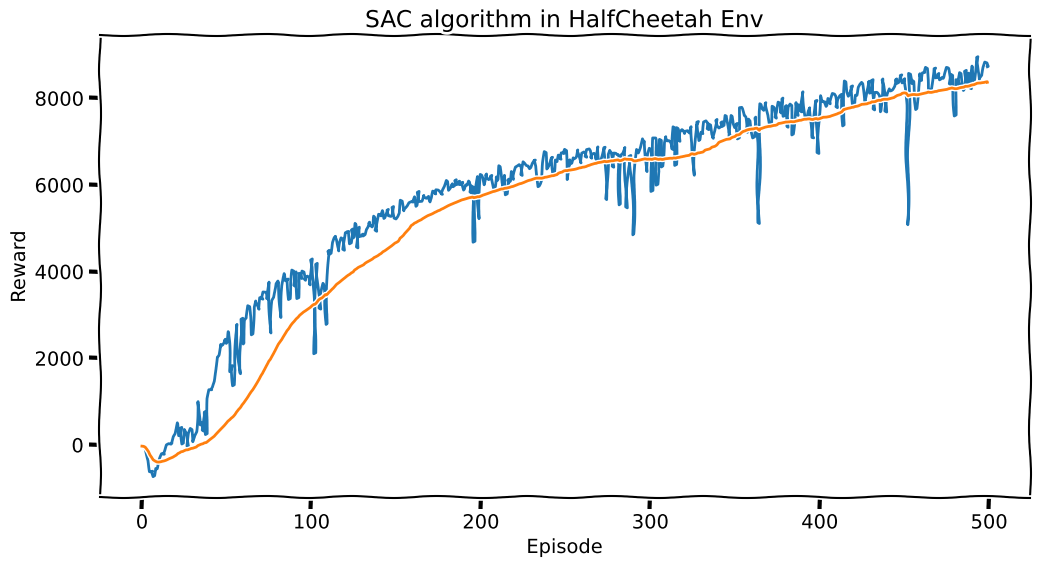

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Training Loop
total_numsteps = 0
updates = 0
reward_history = []
Max_episodes = 500
criteria = 0
max_reward = -1000

for i_episode in range(Max_episodes):
    episode_steps = 0
    done = False
    state, _ = env.reset()

    while not done:
        if config['start_steps'] > total_numsteps:
            action = env.action_space.sample()  # Sample random action
        else:
            action = agent.select_action(state)  # Sample action from policy

        if len(memory) > config['batch_size']:
            critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = agent.update_parameters(memory, config['batch_size'], updates)
            updates += 1

        next_state, reward, done, truncated, _ = env.step(action)  # Step
        episode_steps += 1
        total_numsteps += 1
        done = done or truncated

        # Ignore the "done" signal if it comes from hitting the time horizon.
        mask = 1 if episode_steps == env._max_episode_steps else float(not done)

        memory.push(state, action, reward, next_state, mask)  # Append transition to memory
        state = next_state

    # TODO 14: Evaluate the policy at regular intervals and log the average reward.
    if i_episode % config["eval_interval"] == 0:
        avg_reward = 0.0
        eval_episodes = 10  # Number of episodes for evaluation
        for _ in range(eval_episodes):
            state, _ = env.reset()
            episode_reward = 0
            done = False
            while not done:
                action = agent.select_action(state, evaluate=True)  # Use deterministic policy
                next_state, reward, done, truncated, _ = env.step(action)
                episode_reward += reward
                state = next_state
                done = done or truncated
            avg_reward += episode_reward
        avg_reward /= eval_episodes
        reward_history.append(avg_reward)

    if i_episode % 10 == 0:
        print("Episode: {}, reward: {}".format(i_episode, round(avg_reward, 2)))

    if avg_reward < max_reward:
        criteria += 1
        if criteria == 50:
            break
    else:
        criteria = 0

    max_reward = max(reward_history)


env.close()


plot_rewards(reward_history, show_result='SAC algorithm in HalfCheetah Env')

In [ ]:
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
state, _ = env.reset()
frames = []

total_reward = 0
# run the policy in the environment in a loop
done = False
step = 1000
while step > 0:
    frames.append(env.render())
    action  = agent.select_action(state)
    next_state, reward, done, truncated, _  = env.step(action)
    total_reward += reward
    state = next_state

    done = done or truncated
    step -= 1

env.close()
print(f'Total Reward: {total_reward}')

imageio.mimsave('./eval_SAC.mp4', frames, fps=25)
show_video('./eval_SAC.mp4')

Total Reward: 9526.732607822767


# **Initialize DDPG**

In [29]:
# Configuration dictionary
config = {

    "env_name": "HalfCheetah-v4",
    "policy": "DDPG",
    "gamma": 0.99,
    "tau": 5e-3,
    "lr": 3e-4,
    "alpha": 0.5,
    "seed": 123456,
    "automatic_entropy_tuning": False,
    "batch_size": 256,
    "num_steps": 1e6+1,
    "hidden_size": 256,
    "updates_per_step": 1,
    "start_steps": 1e4,
    "target_update_interval": 1,
    "replay_size": 1e6,
    "policy_noise": 0.2,
    "noise_clip": 0.5,
    "exploration_noise": 0.1,
    "policy_freq": 2,
    "cuda": False,
    "eval_interval": 1,
}

# Setup environment
env = gym.make(config["env_name"])
env.action_space.seed(config["seed"])

# Set random seeds
torch.manual_seed(config["seed"])
np.random.seed(config["seed"])

# Initialize agent
agent = SAC(env.observation_space.shape[0], env.action_space, config)

# Initialize replay memory
memory = ReplayMemory(config["replay_size"], config["seed"])

# **Train the DDPG here**

Episode: 0, Avg Reward: -319.29
Episode: 50, Avg Reward: 1943.4
Episode: 100, Avg Reward: 3216.57
Episode: 150, Avg Reward: 3806.72
Episode: 200, Avg Reward: 4266.88
Episode: 250, Avg Reward: 4614.42
Episode: 300, Avg Reward: 4933.57
Episode: 350, Avg Reward: 5291.67
Episode: 400, Avg Reward: 5633.19
Episode: 450, Avg Reward: 5745.21


<ipython-input-4-12218de9f29c>:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))


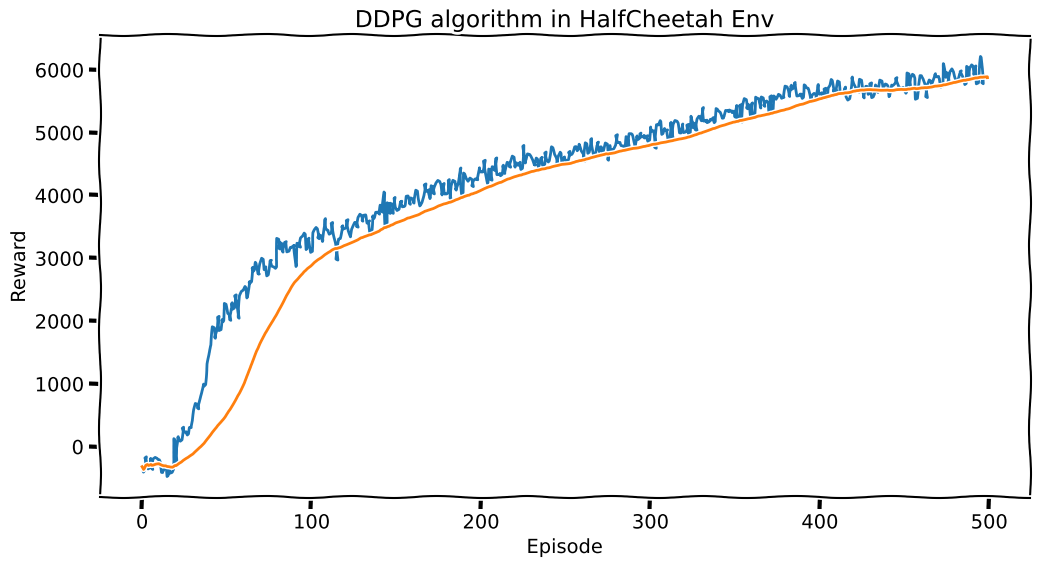

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [30]:
# Training Loop
total_numsteps = 0
updates = 0
reward_history = []
Max_episodes = 500
criteria = 0
max_reward = -1000

for i_episode in range(Max_episodes):
    episode_steps = 0
    done = False
    state, _ = env.reset()
    episode_reward = 0  # Track episode reward

    while not done:
        if total_numsteps < config['start_steps']:
            action = env.action_space.sample()  # Sample random action
        else:
            action = agent.select_action(state)  # Sample action from policy

        next_state, reward, done, truncated, _ = env.step(action)  # Step
        episode_reward += reward  # Accumulate reward
        episode_steps += 1
        total_numsteps += 1
        done = done or truncated  # Consider truncated as done

        # Ignore the "done" signal if it comes from hitting the time horizon
        mask = 1 if episode_steps == env._max_episode_steps else float(not done)

        memory.push(state, action, reward, next_state, mask)  # Store transition
        state = next_state

        if len(memory) > config['batch_size']:
            critic_1_loss, critic_2_loss, policy_loss, ent_loss, alpha = agent.update_parameters(
                memory, config['batch_size'], updates
            )
            updates += 1

    reward_history.append(episode_reward)  # Store episode reward

    # Evaluate policy performance at regular intervals
    if i_episode % 50 == 0:
        avg_reward = np.mean(reward_history[-10:])  # Average reward over last 10 episodes
        print(f"Episode: {i_episode}, Avg Reward: {round(avg_reward, 2)}")

    # Early stopping criteria
    # if avg_reward < max_reward:
    #     criteria += 1
    #     if criteria == 50:
    #         break
    # else:
    #     criteria = 0

    max_reward = max(reward_history)  # Update max reward

env.close()

# Plot rewards over time
plot_rewards(reward_history, show_result="DDPG algorithm in HalfCheetah Env")


In [34]:
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
state, _ = env.reset()
frames = []

total_reward = 0
# run the policy in the environment in a loop
step = 1000
while step > 0:
    step -= 1
    frames.append(env.render())
    action  = agent.select_action(state, evaluate=True)
    next_state, reward, done, truncated, _  = env.step(action)
    total_reward += reward
    state = next_state

    done = done or truncated

env.close()
print(f'Total Reward: {total_reward}')

imageio.mimsave('./eval_DDPG.mp4', frames, fps=25)
show_video('./eval_DDPG.mp4')

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


Total Reward: 6477.454839230867
